## Understanding the local electricity market


💾 The data
You have access to over five years of energy price and demand data (source):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

## 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.

In [1]:
#conda install -c anaconda py-xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import dateutil.parser
from sklearn import linear_model
from pandas.tseries.offsets import MonthEnd
import warnings
warnings.filterwarnings("ignore")

pd.set_option("expand_frame_repr", True)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

col_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

In [3]:
df =  pd.read_csv('energy_demand.csv', parse_dates = True)
df.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2106 non-null   object 
 1   demand            2106 non-null   float64
 2   price             2106 non-null   float64
 3   demand_pos_price  2106 non-null   float64
 4   price_positive    2106 non-null   float64
 5   demand_neg_price  2106 non-null   float64
 6   price_negative    2106 non-null   float64
 7   frac_neg_price    2106 non-null   float64
 8   min_temperature   2106 non-null   float64
 9   max_temperature   2106 non-null   float64
 10  solar_exposure    2105 non-null   float64
 11  rainfall          2103 non-null   float64
 12  school_day        2106 non-null   object 
 13  holiday           2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB


In [5]:
# A copy of the data to be used for creating a model for making the predictions
df1 = df.copy()

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2106 non-null   datetime64[ns]
 1   demand            2106 non-null   float64       
 2   price             2106 non-null   float64       
 3   demand_pos_price  2106 non-null   float64       
 4   price_positive    2106 non-null   float64       
 5   demand_neg_price  2106 non-null   float64       
 6   price_negative    2106 non-null   float64       
 7   frac_neg_price    2106 non-null   float64       
 8   min_temperature   2106 non-null   float64       
 9   max_temperature   2106 non-null   float64       
 10  solar_exposure    2105 non-null   float64       
 11  rainfall          2103 non-null   float64       
 12  school_day        2106 non-null   object        
 13  holiday           2106 non-null   object        
dtypes: datetime64[ns](1), fl

In [8]:
df.describe()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000


In [9]:
#checking for missing values

df.isnull().sum()

date                0
demand              0
price               0
demand_pos_price    0
price_positive      0
demand_neg_price    0
price_negative      0
frac_neg_price      0
min_temperature     0
max_temperature     0
solar_exposure      1
rainfall            3
school_day          0
holiday             0
dtype: int64

In [10]:
#filling the missing data using mode
df['solar_exposure'] = df['solar_exposure'].fillna(df['solar_exposure'].mode()[0])
df['rainfall'] = df['rainfall'].fillna(df['rainfall'].mode()[0])

In [11]:
# Checking for duplicates
df.isnull().sum()

date                0
demand              0
price               0
demand_pos_price    0
price_positive      0
demand_neg_price    0
price_negative      0
frac_neg_price      0
min_temperature     0
max_temperature     0
solar_exposure      0
rainfall            0
school_day          0
holiday             0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [13]:
# Splitting the date time for plotting purposes

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [14]:
df.columns

Index(['date', 'demand', 'price', 'demand_pos_price', 'price_positive',
       'demand_neg_price', 'price_negative', 'frac_neg_price',
       'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall',
       'school_day', 'holiday', 'year', 'month', 'day'],
      dtype='object')

In [15]:
# Drop date column
df.drop('date', axis = 1, inplace = True)

In [16]:
df.sample(3)

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,day
1850,102445.880,50.132823,102445.88,50.132823,0.000,0.00000,0.000000,13.0,27.4,30.0,0.0,N,N,2020,1,25
1921,105098.025,23.780908,79509.45,36.334744,25588.575,-15.22668,0.270833,9.5,16.9,4.5,4.4,N,N,2020,4,5
1385,112592.260,122.200670,112592.26,122.200670,0.000,0.00000,0.000000,16.1,22.6,15.1,5.2,Y,N,2018,10,17


In [17]:
# Checking the cardinality of the year column
len(df.year.unique())

6

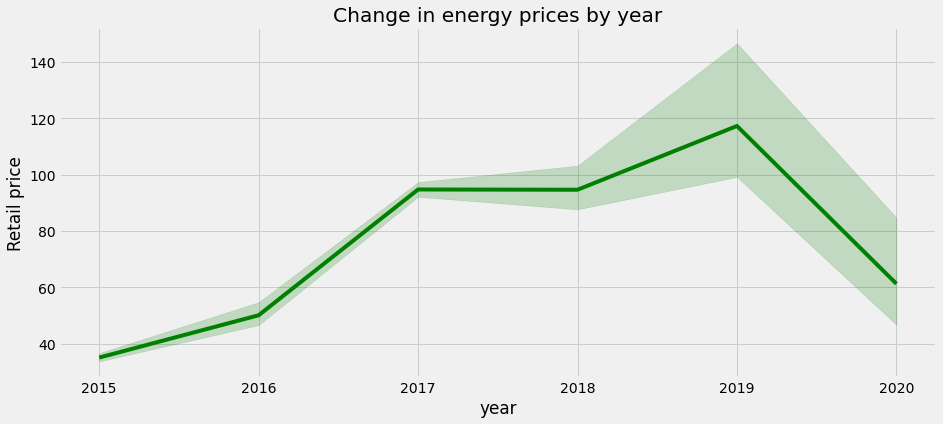

In [18]:
# Y axis is price closing
plt.figure(figsize=(14,6))
sns.lineplot(y='price', x ='year', data = df, color = "green")
plt.title("Change in energy prices by year")
plt.ylabel("Retail price")
plt.show()

In [19]:
my = df.groupby(['year', 'month', 'day'], as_index =False)['price'].mean()
my.sample(3)

,year,month,day,price
1226,2018,5,11,63.673070
1877,2020,2,21,48.658203
458,2016,4,3,15.804000


In [20]:
my2 = df.groupby(['year', 'month'], as_index =False)['price'].mean()
my2.sample(3)

,year,month,price
15,2016,4,47.962939
33,2017,10,74.471315
21,2016,10,34.440483


In [21]:
my3 = df.groupby('month')[['price']].mean()
my3.sample(3)

,price
month,
12,66.229981
9,68.578842
6,81.245597


In [22]:
my4 = df.groupby('year')[['price']].mean()
my4.sample(3)

,price
year,
2019,117.281370
2017,94.740161
2016,50.094252


In [23]:
#add a new date time column to my2 dataframe with the date as the end of the month
my2['datetime'] = pd.to_datetime(my2.year.astype(str) + my2.month.astype(str), format = '%Y%m') + MonthEnd(1)
my2.sample(3)

,year,month,price,datetime
56,2019,9,109.025825,2019-09-30
15,2016,4,47.962939,2016-04-30
48,2019,1,298.171896,2019-01-31


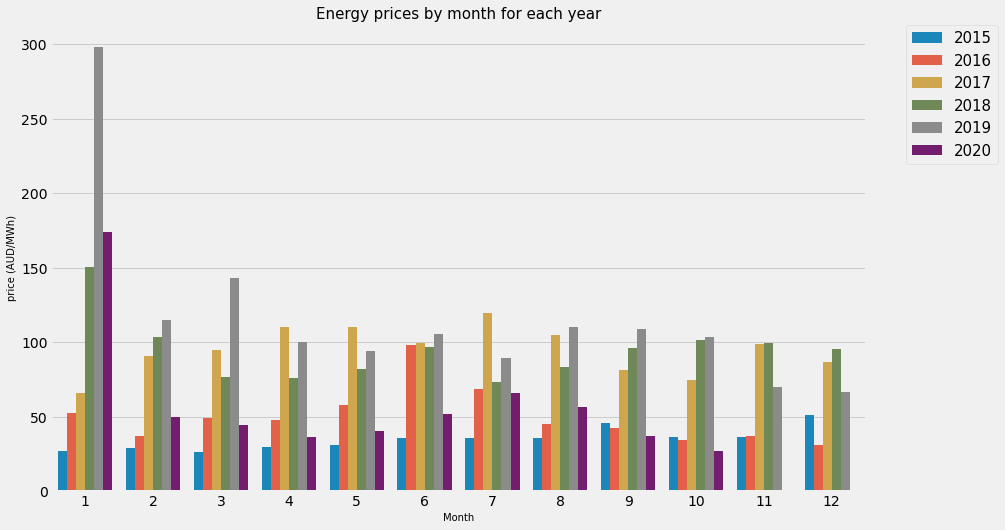

In [24]:
# Prices by month and year
plt.figure(figsize = (13, 8))
sns.barplot(data = my2, x = 'month', y = 'price', hue = 'year')
plt.legend(bbox_to_anchor = (1.05, 1), borderaxespad = 0,fontsize = 15)
plt.title('Energy prices by month for each year',fontsize = 15)
plt.ylabel('price (AUD/MWh)',fontsize = 10)
plt.xlabel("Month",fontsize = 10)
plt.show()

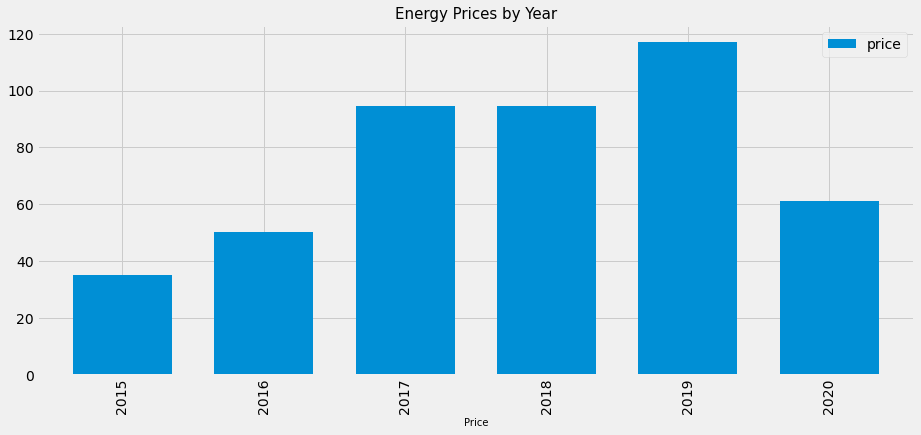

In [25]:
#Prices by year
my4.plot(kind = 'bar', width = 0.7, figsize = (14,6))
plt.title("Energy Prices by Year", fontsize = 15)
plt.xlabel("Year",fontsize = 10)
plt.xlabel("Price",fontsize = 10)
plt.show()

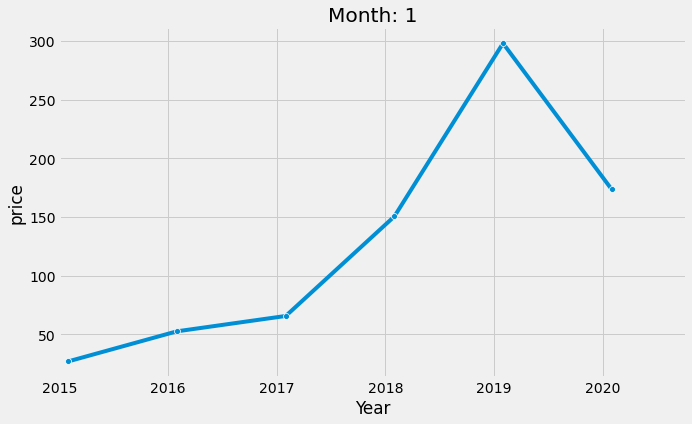

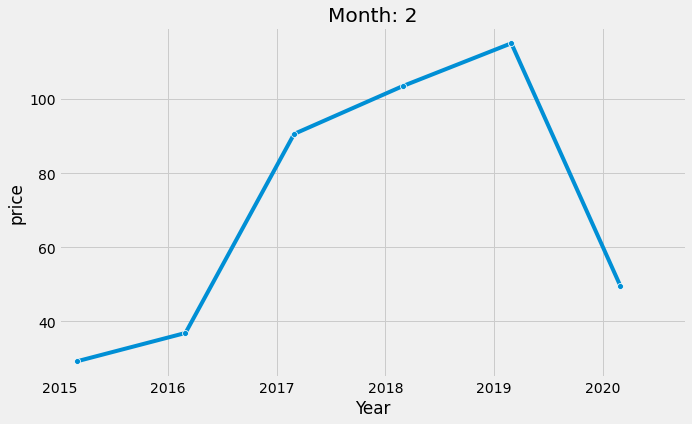

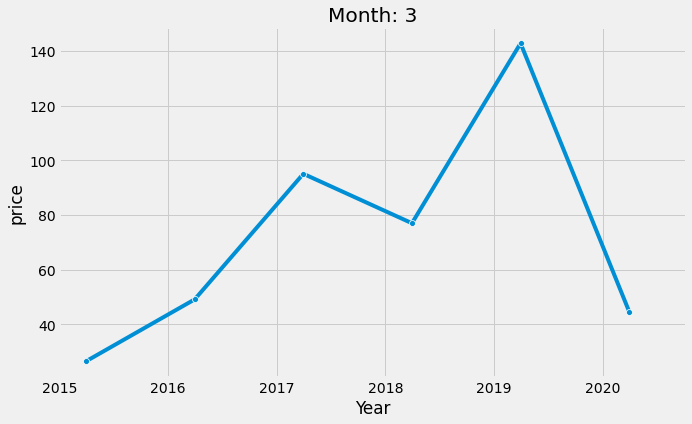

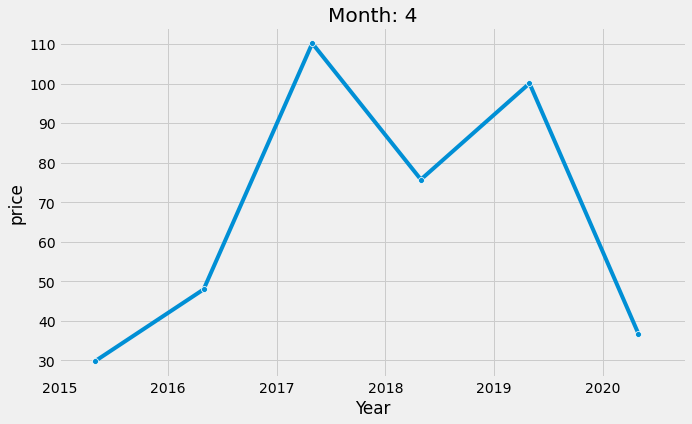

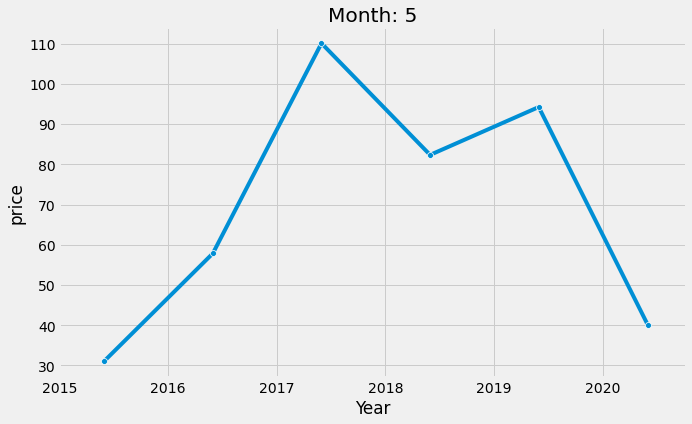

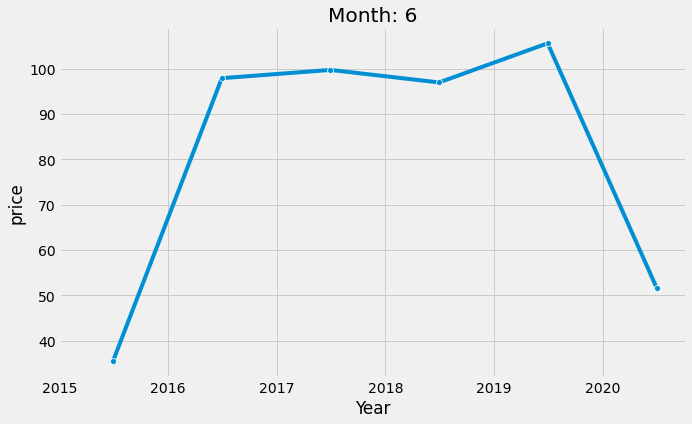

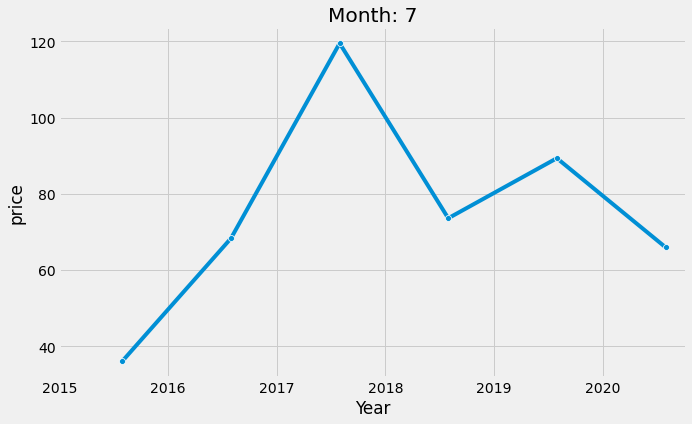

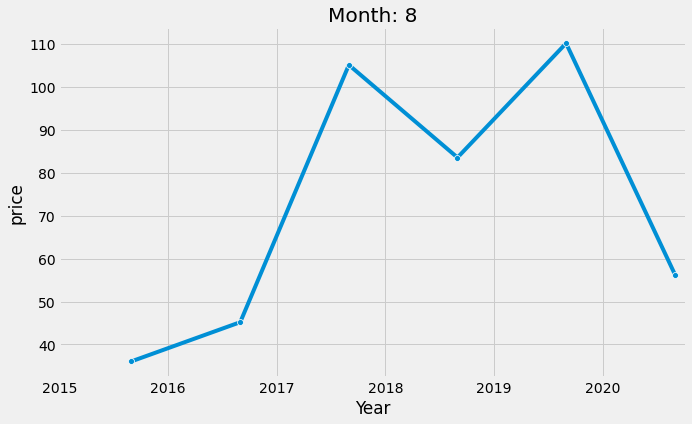

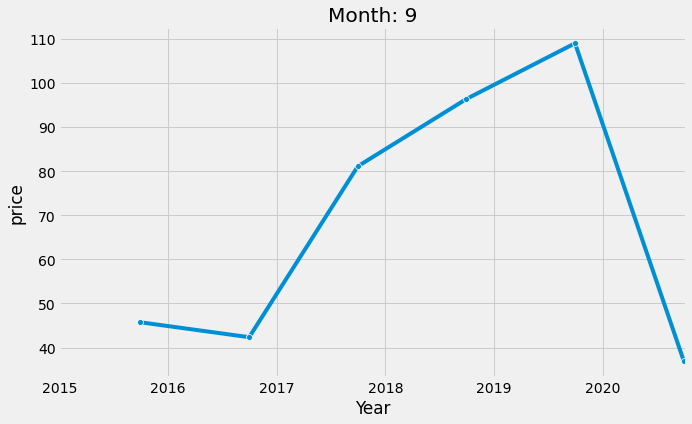

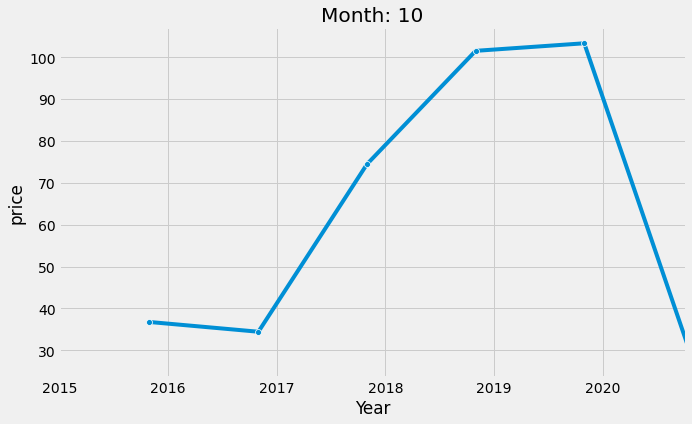

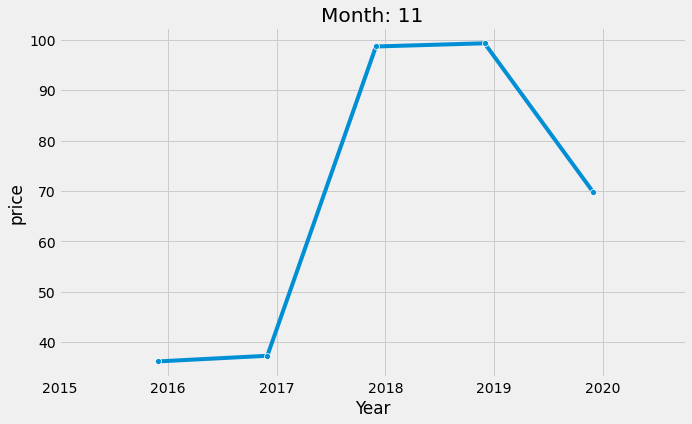

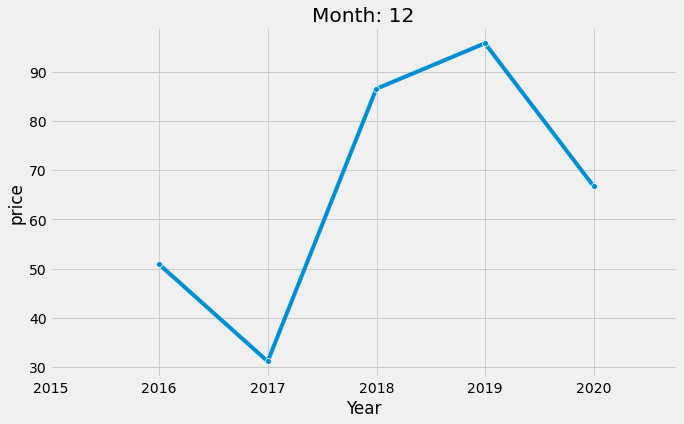

In [26]:
for month in my2.month.unique():
    data = my2[my2.month == month]
    plt.figure(figsize=(10,6))
    sns.lineplot(data.datetime, data.price, marker = 'o')
    plt.xlim(datetime(2015, 1, 1), datetime(2020, 10, 6))
    plt.title(f'Month: {month}')
    plt.ylabel('price')
    plt.xlabel('Year')

# seasons in australia
- #Summer - three hottest month which falls in December to February 
- #Autumn - the transition month which falls in March to May  
- #Winter - the three coldest months falls in June to August 
- #spring - the three transition months which is September to November  


### Lets represent the months in numbers
- 1 = Summer (months id 12th - 2nd)
- 2 = Autumn (months id 3th - 5th)
- 3 = Winter (months id 6th - 8th)
- 4 = Spring (months id 9th - 11th)


In [27]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season= dict(zip(range(1, 13), seasons))
df['season_id'] = df.month.map(month_to_season)
df['season'] = df['season_id'].map({1:'Summer', 2:'Autumn', 3:'Winter', 4:'Spring'})
df['rain'] = df['rainfall'] > 1

In [28]:
# Patterns by seasons
price_by_season = df.groupby(['season'], as_index = False)['price'].mean()
price_by_season

,season,price
0,Autumn,69.517789
1,Spring,68.451242
2,Summer,90.115702
3,Winter,76.433038


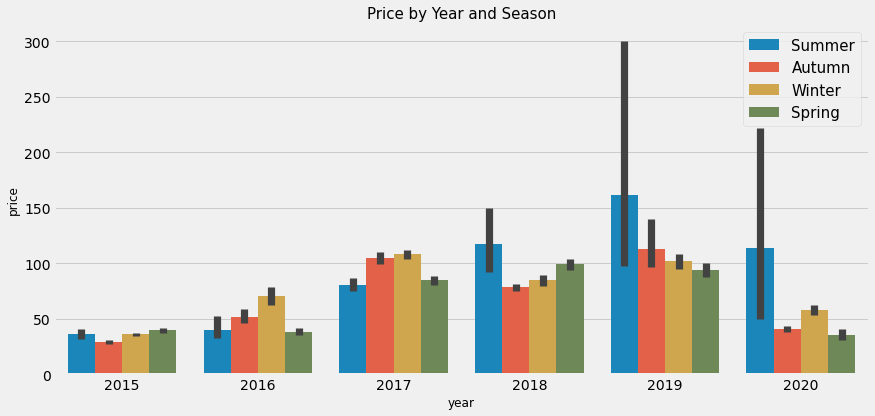

In [29]:
# comparing price by season..
plt.figure(figsize=(13,6))
sns.barplot(data = df, x = 'year', y = 'price', hue = 'season')
plt.legend(bbox_to_anchor = (1,1), fontsize = 15)
plt.xlabel('year', fontsize = 12)
plt.ylabel('price', fontsize = 12)
plt.title('Price by Year and Season', fontsize = 15)
plt.show()

### Forecast of daily energy prices the company can use as the basis of its financial planning.

In [30]:
df1.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [31]:
df1.index = pd.to_datetime(df1['date'])
df1.drop("date",axis = 1, inplace = True)
df1.sample(3)

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2016-02-19,122991.660,43.694897,122991.660,43.694897,0.0,0.0,0.0,15.8,22.0,11.2,0.2,Y,N
2015-11-20,123412.685,38.026498,123412.685,38.026498,0.0,0.0,0.0,15.4,19.1,6.4,0.4,Y,N
2017-11-10,115156.445,92.615537,115156.445,92.615537,0.0,0.0,0.0,12.1,27.2,23.7,0.0,Y,N


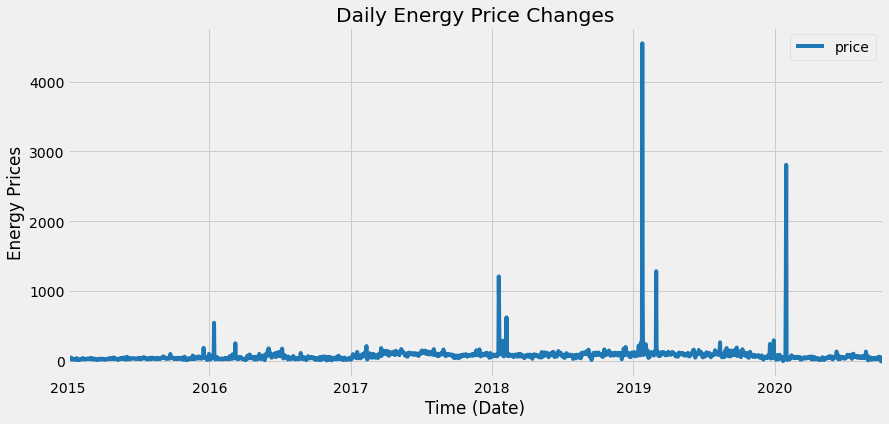

In [32]:
# Daily energy price chnages
df1.plot(y = 'price', color= col_pal[0],figsize = (13,6))
plt.title("Daily Energy Price Changes")
plt.ylabel("Energy Prices")
plt.xlabel("Time (Date)")
plt.show()

Text(0, 0.5, 'Rainfall')

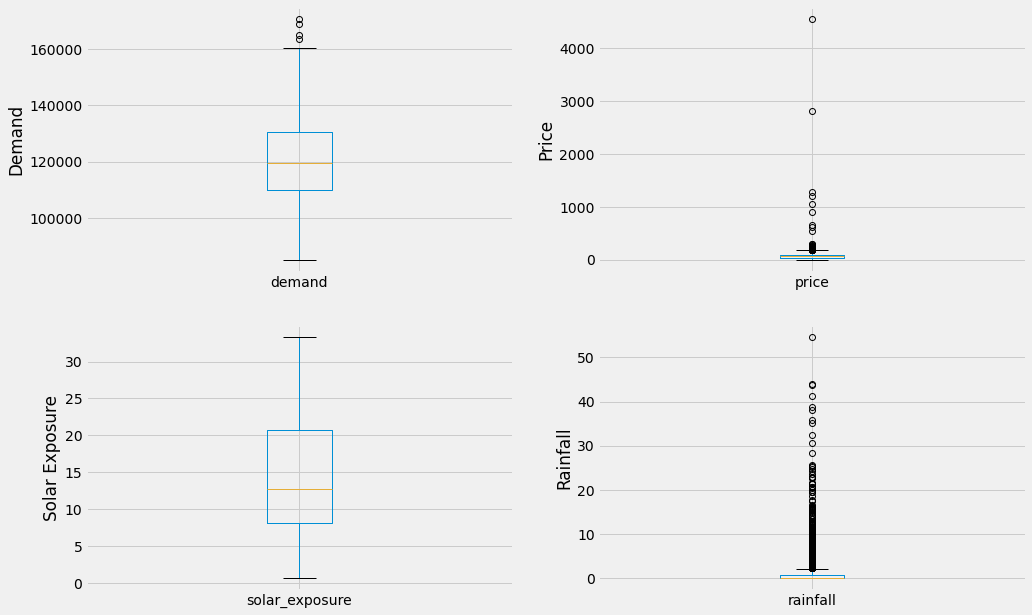

In [33]:
#Check for outliers
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = df1.boxplot(column='demand')
fig.set_ylabel('Demand')

plt.subplot(2,2,2)
fig = df1.boxplot(column='price')
fig.set_ylabel('Price')

plt.subplot(2,2,3)
fig = df1.boxplot(column='solar_exposure')
fig.set_ylabel('Solar Exposure')

plt.subplot(2,2,4)
fig = df1.boxplot(column='rainfall')
fig.set_ylabel('Rainfall')

### Train and Test Split


In [34]:
len(df1.index)

2106

In [35]:
# An estimate of around where the 70% of the data lies below(train set)
df1.iloc[1475]

demand              152496.245
price               222.438419
demand_pos_price    152496.245
price_positive      222.438419
demand_neg_price           0.0
price_negative             0.0
frac_neg_price             0.0
min_temperature           19.4
max_temperature           30.4
solar_exposure            22.3
rainfall                   0.0
school_day                   N
holiday                      N
Name: 2019-01-15 00:00:00, dtype: object

In [36]:
# splitting the date
df1['year'] = df1.index.year
df1['month'] = df1.index.month
df1['day'] = df1.index.day
df1['day of week'] = df1.index.dayofweek

In [37]:
# Splitting the date into test and train data
split_date = '2019-01-01'
train = df1[df1.index < pd.to_datetime(split_date)]
test = df1[df1.index >= pd.to_datetime(split_date)] 

In [38]:
train.shape

(1461, 17)

In [39]:
test.shape

(645, 17)

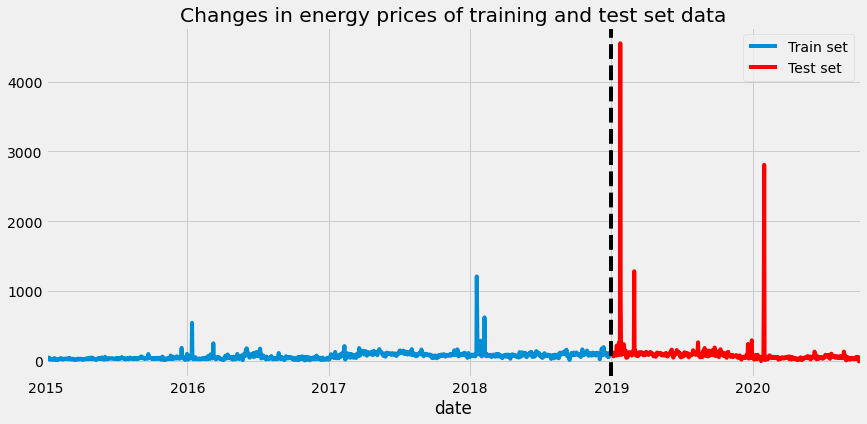

In [40]:
fig, ax = plt.subplots(figsize=(13,6))
train.price.plot()
test.price.plot(color = "r")
plt.title("Changes in energy prices of training and test set data")
ax.axvline('2019-1-1', color = "black", ls ="--")
ax.legend(["Train set", "Test set"])
plt.show()

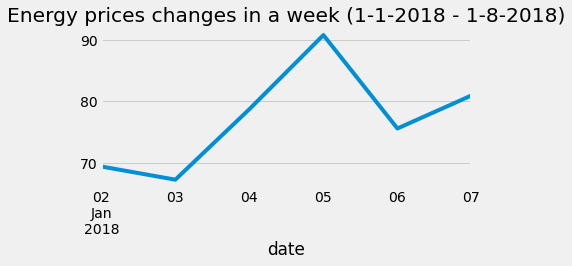

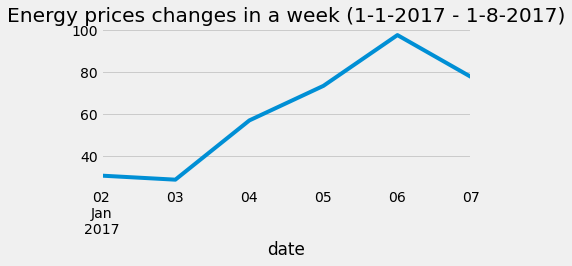

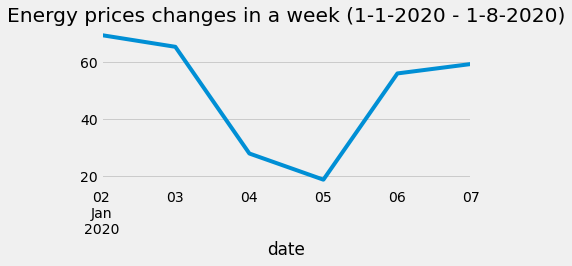

In [41]:
# Energy price changes in a random week
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
df1.loc[(df1.index > "1-1-2018") & (df1.index < "1-8-2018")].price.plot(figsize=(13,6))
plt.title("Energy prices changes in a week (1-1-2018 - 1-8-2018)")
plt.show()

plt.subplot(2,2,2)
df1.loc[(df1.index > "1-1-2017") & (df1.index < "1-8-2017")].price.plot(figsize=(13,6))
plt.title("Energy prices changes in a week (1-1-2017 - 1-8-2017)")
plt.show()

plt.subplot(2,2,3)
df1.loc[(df1.index > "1-1-2020") & (df1.index < "1-8-2020")].price.plot(figsize=(13,6))
plt.title("Energy prices changes in a week (1-1-2020 - 1-8-2020)");

<AxesSubplot:xlabel='day of week', ylabel='demand'>

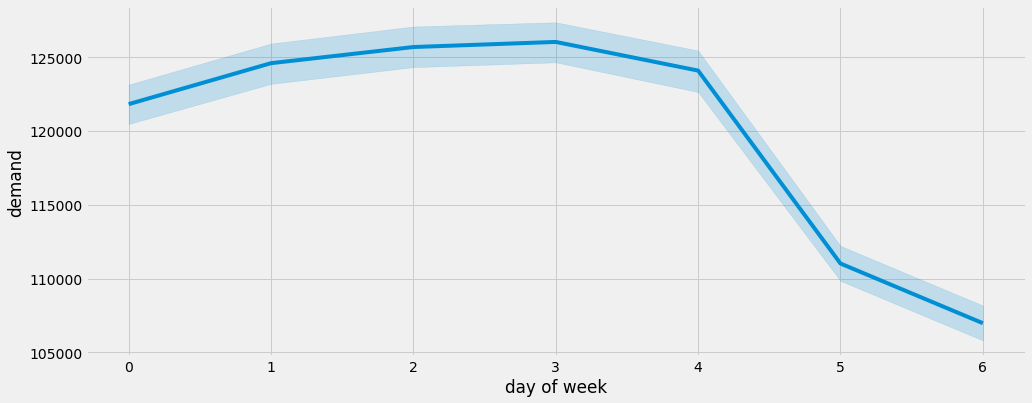

In [42]:
# Energy demand in a week
plt.subplots(figsize=(15,6))
sns.lineplot(data = df1, x = "day of week", y ="demand")

<AxesSubplot:xlabel='day of week', ylabel='price'>

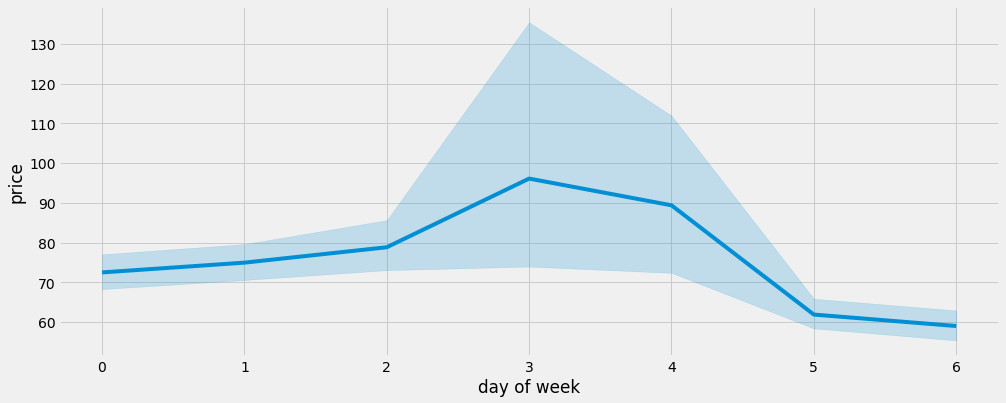

In [43]:
# Energy demand in a week
plt.subplots(figsize=(15,6))
sns.lineplot(data = df1, x = "day of week", y ="price")

In [44]:
features = df1.drop("price", axis = 1).columns
print("Features: ", features)
target = 'price'
print("Target: ",target)

Features:  Index(['demand', 'demand_pos_price', 'price_positive', 'demand_neg_price',
       'price_negative', 'frac_neg_price', 'min_temperature',
       'max_temperature', 'solar_exposure', 'rainfall', 'school_day',
       'holiday', 'year', 'month', 'day', 'day of week'],
      dtype='object')
Target:  price


In [45]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [46]:
#check the shape of our split data

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1461, 16) (645, 16)
(1461,) (645,)


In [47]:
X_train.columns

Index(['demand', 'demand_pos_price', 'price_positive', 'demand_neg_price',
       'price_negative', 'frac_neg_price', 'min_temperature',
       'max_temperature', 'solar_exposure', 'rainfall', 'school_day',
       'holiday', 'year', 'month', 'day', 'day of week'],
      dtype='object')

In [48]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [49]:
def missing_values(x):
    return (sum(x.isna()))
print("Missing values for each split: \n")

print("y_train: \n",y_train.apply(missing_values).where(lambda x:x!=0).dropna(),'\n')
print("y_test: \n",y_test.apply(missing_values).where(lambda x:x!=0).dropna(),'\n')
print("X_train: \n",X_train.apply(missing_values).where(lambda x:x!=0).dropna(),'\n')
print("X_test: \n",X_test.apply(missing_values).where(lambda x:x!=0).dropna())

Missing values for each split: 

y_train: 
 Series([], dtype: float64) 

y_test: 
 Series([], dtype: float64) 

X_train: 
 solar_exposure    1.0
rainfall          3.0
dtype: float64 

X_test: 
 Series([], dtype: float64)


In [50]:
# filling missing values with mode.
X_train['solar_exposure'] = X_train['solar_exposure'].fillna(X_train['solar_exposure'].mode()[0])
X_train['rainfall'] = X_train['rainfall'].fillna(X_train['rainfall'].mode()[0])

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2015-01-01 to 2018-12-31
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   demand            1461 non-null   float64
 1   demand_pos_price  1461 non-null   float64
 2   price_positive    1461 non-null   float64
 3   demand_neg_price  1461 non-null   float64
 4   price_negative    1461 non-null   float64
 5   frac_neg_price    1461 non-null   float64
 6   min_temperature   1461 non-null   float64
 7   max_temperature   1461 non-null   float64
 8   solar_exposure    1461 non-null   float64
 9   rainfall          1461 non-null   float64
 10  school_day        1461 non-null   object 
 11  holiday           1461 non-null   object 
 12  year              1461 non-null   int64  
 13  month             1461 non-null   int64  
 14  day               1461 non-null   int64  
 15  day of week       1461 non-null   int64  
dtypes: float64(10), int64(4)

In [52]:
#extraxt the categorical features 
categorical = [var for var in X_train.columns if X_train[var].dtype=='O']

print('There are {} categorical variables \n'.format(len(categorical)))

print('They are: ', categorical)

There are 2 categorical variables 

They are:  ['school_day', 'holiday']


In [53]:
numerical = [var for var in X_train.columns if X_train[var].dtype!='O']

print('There are {} numerical variables. \n'.format(len(numerical)))

print('They are: \n', numerical)

There are 14 numerical variables. 

They are: 
 ['demand', 'demand_pos_price', 'price_positive', 'demand_neg_price', 'price_negative', 'frac_neg_price', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'year', 'month', 'day', 'day of week']


In [54]:
print("Unique values in school day:", X_train.school_day.unique())
print("Unique values in holiday:", X_train.holiday.unique())

Unique values in school day: ['N' 'Y']
Unique values in holiday: ['Y' 'N']


In [55]:
#encoding categorocal data 
import category_encoders as ce

encoder =ce.BinaryEncoder(cols=['school_day', 'holiday'])
X_train= encoder.fit_transform(X_train)
X_test= encoder.fit_transform(X_test)

In [56]:
X_train.columns

Index(['demand', 'demand_pos_price', 'price_positive', 'demand_neg_price',
       'price_negative', 'frac_neg_price', 'min_temperature',
       'max_temperature', 'solar_exposure', 'rainfall', 'school_day_0',
       'school_day_1', 'holiday_0', 'holiday_1', 'year', 'month', 'day',
       'day of week'],
      dtype='object')

In [57]:
X_train.sample(3)

,demand,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day_0,school_day_1,holiday_0,holiday_1,year,month,day,day of week
date,,,,,,,,,,,,,,,,,,
2016-06-29,136071.965,136071.965,80.125243,0.0,0.0,0.0,8.9,15.8,8.9,0.2,0,1,1,0,2016,6,29,2
2018-06-13,131574.605,131574.605,84.579533,0.0,0.0,0.0,9.5,14.1,7.1,0.0,1,0,1,0,2018,6,13,2
2018-11-22,107278.830,107278.830,77.208903,0.0,0.0,0.0,9.7,16.4,20.3,6.2,1,0,1,0,2018,11,22,3


In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2015-01-01 to 2018-12-31
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   demand            1461 non-null   float64
 1   demand_pos_price  1461 non-null   float64
 2   price_positive    1461 non-null   float64
 3   demand_neg_price  1461 non-null   float64
 4   price_negative    1461 non-null   float64
 5   frac_neg_price    1461 non-null   float64
 6   min_temperature   1461 non-null   float64
 7   max_temperature   1461 non-null   float64
 8   solar_exposure    1461 non-null   float64
 9   rainfall          1461 non-null   float64
 10  school_day_0      1461 non-null   int64  
 11  school_day_1      1461 non-null   int64  
 12  holiday_0         1461 non-null   int64  
 13  holiday_1         1461 non-null   int64  
 14  year              1461 non-null   int64  
 15  month             1461 non-null   int64  
 16  day               1461 n

In [59]:
X_test.head()

,demand,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day_0,school_day_1,holiday_0,holiday_1,year,month,day,day of week
date,,,,,,,,,,,,,,,,,,
2019-01-01,98933.060,98933.060,78.560979,0.0,0.0,0.0,15.5,26.2,31.7,0.0,0,1,0,1,2019,1,1,1
2019-01-02,106470.675,106470.675,92.202011,0.0,0.0,0.0,18.4,22.2,26.3,0.0,0,1,1,0,2019,1,2,2
2019-01-03,118789.605,118789.605,127.380303,0.0,0.0,0.0,15.9,29.5,27.6,0.0,0,1,1,0,2019,1,3,3
2019-01-04,133288.460,133288.460,121.020997,0.0,0.0,0.0,18.0,42.6,27.4,0.0,0,1,1,0,2019,1,4,4
2019-01-05,97262.790,97262.790,83.493520,0.0,0.0,0.0,17.4,21.2,12.9,0.4,0,1,1,0,2019,1,5,5


In [60]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645 entries, 2019-01-01 to 2020-10-06
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   demand            645 non-null    float64
 1   demand_pos_price  645 non-null    float64
 2   price_positive    645 non-null    float64
 3   demand_neg_price  645 non-null    float64
 4   price_negative    645 non-null    float64
 5   frac_neg_price    645 non-null    float64
 6   min_temperature   645 non-null    float64
 7   max_temperature   645 non-null    float64
 8   solar_exposure    645 non-null    float64
 9   rainfall          645 non-null    float64
 10  school_day_0      645 non-null    int64  
 11  school_day_1      645 non-null    int64  
 12  holiday_0         645 non-null    int64  
 13  holiday_1         645 non-null    int64  
 14  year              645 non-null    int64  
 15  month             645 non-null    int64  
 16  day               645 non

In [61]:
#feature scaling`
scaler= MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [62]:
# Model
# an estimation of 1000 trees to be created
model = xgb.XGBRegressor(n_estimator = 1000, early_stopping_rounds = 50, learning_rate = 0.1)
model.fit(X_train, y_train,eval_set= [(X_train, y_train),( X_test, y_test)], verbose = 10)#True so that you can see the model train

[17:58:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rmse:78.11403	validation_1-rmse:234.96259
[10]	validation_0-rmse:31.85523	validation_1-rmse:206.09387
[20]	validation_0-rmse:14.84897	validation_1-rmse:192.16578
[30]	validation_0-rmse:7.77317	validation_1-rmse:184.57245
[40]	validation_0-rmse:4.39702	validation_1-rmse:180.38736
[50]	validation_0-rmse:2.58362	validation_1-rmse:178.04991
[60]	validation_0-rmse:1.54986	validation_1-rmse:176.66196
[70]	validation_0-rmse:0.94759	validation_1-rmse:175.86546
[80]	validation_0-rmse:0.59968	validation_1-rmse:175.39540
[90]	validation_0-rmse:0.40597	validation_1-rmse:175.11223
[99]	validation_0-rmse:0.31197	validation_1-rmse:174.95185


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimator=1000, n_estimators=100,
             n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

### Forecast on the test data

In [63]:
y_pred = model.predict(X_test)

In [64]:
y_pred = pd.DataFrame(y_pred, columns = ['Predicted energy prices'])
y_pred.head(3)

,Predicted energy prices
0,30.785151
1,34.032856
2,43.501045


In [65]:
y_test.head(3)

,price
date,
2019-01-01,78.560979
2019-01-02,92.202011
2019-01-03,127.380303


In [66]:
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
rmse

174.9518464452088

In [67]:
mae = mean_absolute_error(y_test,y_pred)
mae

59.073529425444185

In [68]:
df1.index.max()

Timestamp('2020-10-06 00:00:00')

### forecasting prices for the next one year

In [69]:
df1.index.max()

Timestamp('2020-10-06 00:00:00')

In [70]:
# Creating a future data frame of one year for each of the days
dates = pd.date_range('2020-10-7','2021-10-6', freq = '1d')
dates

DatetimeIndex(['2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
               '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16',
               ...
               '2021-09-27', '2021-09-28', '2021-09-29', '2021-09-30',
               '2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06'],
              dtype='datetime64[ns]', length=365, freq='D')

In [71]:
dates_df = pd.DataFrame(index =dates)
dates_df.head()

""
2020-10-07
2020-10-08
2020-10-09
2020-10-10
2020-10-11
